In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #easier to operate with, numpy based..!
from ipywidgets import interact
import timeit
import time
import os

In [2]:
#Folder and paths definitions
main_path  = os.getcwd()
datafolder_path = main_path+"/results"
results_dir = "/output_py" 
output_dir = main_path+results_dir
try:
    os.mkdir(output_dir)
except OSError:
    print ("Creation of the directory %s failed" % results_dir)
else:
    print ("Successfully created the directory %s " % results_dir)


Creation of the directory /output_py failed


In [3]:
def convert_to_df(mat):
    return pd.DataFrame(mat)
def makeGaussian(size = 100, fwhm = 50, center=None):
    """ Make a square gaussian kernel 2d."""

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def get_distrib_mat(grid):
    """Here only one step is needed in a given direction"""
    df_grid = convert_to_df(grid)
    N = df_grid.shift(1,axis=0,fill_value=0)  #looks 1 cell up
    E = df_grid.shift(-1,axis=1,fill_value=0) #looks 1 cell right
    S = df_grid.shift(-1,axis=0,fill_value=0) #looks 1 cell down 
    W = df_grid.shift(1,axis=1,fill_value=0)  #looks 1 cell left 
    return N,E,S,W


c1=c4 = 3e3
c2=c5 = 1.1e4
c3=c6 = 1e-3
beta = gamma = 2



def r1(i,j):
    return c1/(c2+j**beta)
def r2(i,j):
    return c3*i
def r3(i,j):
    return c4/(c5+i**gamma)
def r4(i,j):
    return c6*j

#mapping reaction functions
#note that these coefficients are fixed during the exp, can be evaluated even just once!

#all weights for the reactions
size = 100
a = np.zeros(shape=[4,size,size])

for i in range(0,size):
    for j in range(0,size):
        a[0,i,j] = r1(i,j)
        a[1,i,j] = r2(i,j)
        a[2,i,j] = r3(i,j) 
        a[3,i,j] = r4(i,j) 

a_df=[]
a_df.append(convert_to_df(a[0,:,:]))
a_df.append(convert_to_df(a[1,:,:]))
a_df.append(convert_to_df(a[2,:,:]))
a_df.append(convert_to_df(a[3,:,:]))

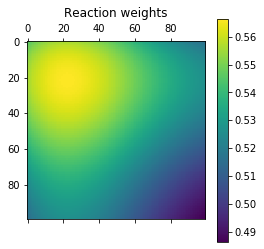

In [4]:
plt.matshow(a_df[0]+a_df[1]+a_df[2]+a_df[3])
plt.title("Reaction weights",y=1.1)
plt.colorbar()
plt.show()

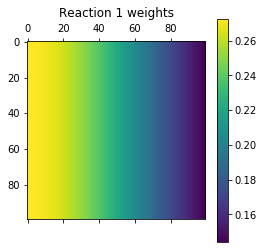

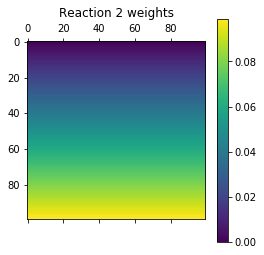

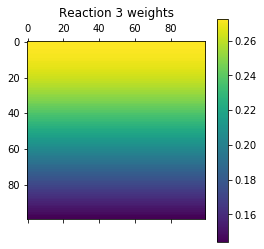

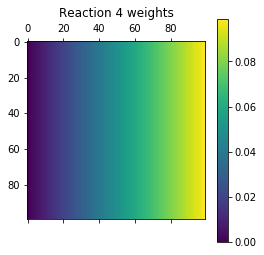

In [5]:
#Coefficients matrices
for i in range(0,4):
    plt.matshow(a_df[i])
    plt.title("Reaction %d weights"%(i+1),y=1.1)
    plt.colorbar()
    plt.show()
    #plt.clim(0, .5);

In [6]:
def create_size_folderdata(size):
    try:
        os.mkdir(output_dir+"/size=%d"%(size))
    except OSError:
        print ("Creation of the directory %s failed" % output_dir+"/size=%d"%(size))
    else:
        print ("Successfully created the directory %s " % output_dir+"/size=%d"%(size))
    return output_dir+"/size=%d"%(size)

#create_name/get data functions

def name_data(t_end):
    data_name = "data_size%d_x0y0=%d_%d_std=%d_t_end=%d.dat"%(size,center[0],center[1],std,t_end)
    return data_name

def get_data(output_path,t_end):
    data_name = "data_size%d_x0y0=%d_%d_std=%d_t=%d.dat"%(size,center[0],center[1],std,t_end)
    data = pd.read_csv(output_path,header=None,sep=",")
    return data


#visualization functions


def display_sequence_contourf(output_path,t_end):
    data = get_data(output_path,t_end)
    def _show(frame=(0, t_end-1)):
        plt.style.use('seaborn-white')

        plt.title("%d step"%(frame),y=1.1)
        plt.contourf(get_configuration(data, frame),10,cmap='Spectral') # n equally spaced lines
        plt.colorbar()
        #plt.clim(0,1)
        plt.show()
    return interact(_show)

def get_configuration(data, t):
    return convert_to_df(np.asarray(data.iloc[t]).reshape(size,size))

In [7]:
def time_ev_mat(grid,t_end=50):

    start_t = time.clock()
    t = 0  
    size = np.shape(grid)[0]
    a = np.zeros(shape=[4,size,size])
    Id_mat = np.eye(size)
    full1_mat = np.full([size,size],1)
    
    result_path_name = create_size_folderdata(size)
    
    filePath = result_path_name+"/"+name_data(t_end)
 
    #to avoid overwrite
    if os.path.exists(filePath):
        os.remove(filePath)
    
    print("\n")
    
    grid = convert_to_df(grid)
    for i in range(0,size):
        for j in range(0,size):
            a[0,i,j] = r1(i,j)
            a[1,i,j] = r2(i,j)
            a[2,i,j] = r3(i,j) 
            a[3,i,j] = r4(i,j) 

    a_df=[]
    a_df.append(convert_to_df(a[0,:,:]))
    a_df.append(convert_to_df(a[1,:,:]))
    a_df.append(convert_to_df(a[2,:,:]))
    a_df.append(convert_to_df(a[3,:,:]))
    
    t_flag=5
    while t<t_end+1: #not to lose last step
        #running flag
        if(t%int(t_end/t_flag))==0:
            print("Process @%d/%d (%.2f/100)"%(t,t_end,(100*(t)/t_end)))
            print("Normalized sum of grid %.8f"%(sum(sum(grid.values))/(size*size)))
            print("Elapsed time = %.3fseconds\n"%(time.clock()-start_t))    
            #not to lose first step
        
        (convert_to_df(grid.values.flatten()).T).to_csv(result_path_name+"/"+name_data(t_end),header=None,index=None,sep=",",float_format='%f',mode='a')

        #working directly on matrices to avoid nested for loops with plenty fo evaluations
        
        shifted_distrib = get_distrib_mat(grid)
        N = shifted_distrib[0]
        E = shifted_distrib[1]
        S = shifted_distrib[2]
        W = shifted_distrib[3]
        
        increment = np.zeros(shape=[size,size])
        increment = increment + (W-grid).values*grid.values*a_df[0].values
        increment = increment + (E-grid).values*grid.values*a_df[1].values
        increment = increment + (N-grid).values*grid.values*a_df[2].values
        increment = increment + (S-grid).values*grid.values*a_df[3].values
        
        #implement mask for thresholds
        
        
        grid = grid + increment
        t+=1

    end_t = time.clock()
    print("\n\nDone in %.3fseconds"%(end_t-start_t))    
    
    return result_path_name+"/"+name_data(t_end)


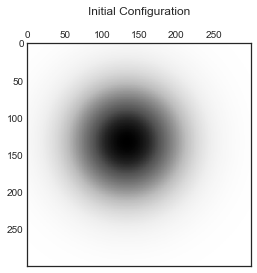

Successfully created the directory /Users/sergiopicella/Desktop/Utrecht/Utrecht_University/UU/CS Thesis/Ivan/Py/output_py /size=300


Process @0/5000 (0.00/100)
Normalized sum of grid 0.21798606
Elapsed time = 0.311seconds

Process @1000/5000 (20.00/100)
Normalized sum of grid 0.13957426
Elapsed time = 560.530seconds



In [ ]:
size = 3
std = size/5
center = [size/2,size/2]

size = 300
std = 266/2
center = [133,133]


t_end = 5000

grid = convert_to_df(makeGaussian(size=size,center=center, fwhm = std))
plt.matshow(grid)
plt.title("Initial Configuration",y=1.1)
plt.show()
output_path = time_ev_mat(grid,t_end=t_end) #execute and returns path of data output 


In [12]:
display_sequence_contourf(output_path,t_end)

interactive(children=(IntSlider(value=24, description='frame', max=49), Output()), _dom_classes=('widget-inter…

<function __main__.display_sequence_contourf.<locals>._show(frame=(0, 49))>